In [1]:
import numpy as np
from tsai.all import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_curve, auc, confusion_matrix, roc_auc_score, f1_score, accuracy_score, classification_report
from utils import *
from sklearn.preprocessing import StandardScaler
import sklearn_crfsuite
from sklearn_crfsuite import metrics

In [2]:
error_signal = np.loadtxt(r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PRDPE/e.csv', delimiter=',')
u_signal =np.loadtxt(r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PRDPE/u.csv', delimiter=',')
tc = np.loadtxt(r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PRDPE/mdist.csv', delimiter=',')

error_signal = error_signal[:, 0]
u_signal = u_signal[:, 0]
tc = tc[:, 0]

print(f"{tc.shape=}; {error_signal.shape=}; {u_signal.shape=}")

tc.shape=(12000,); error_signal.shape=(12000,); u_signal.shape=(12000,)


Classification report:
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98     11523
         1.0       0.00      0.00      0.00       476

    accuracy                           0.96     11999
   macro avg       0.48      0.50      0.49     11999
weighted avg       0.92      0.96      0.94     11999



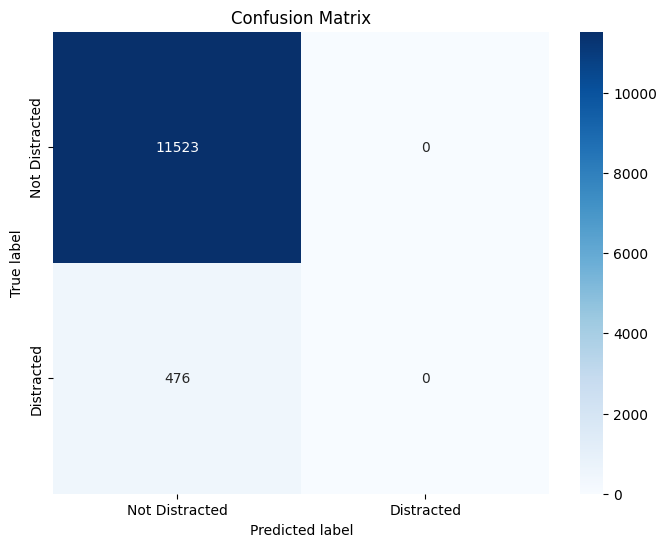

Top 5 feature weights:
('error_signal', '0.0'): 0.017911
('u_signal', '1.0'): 0.011297


In [3]:
scaler = StandardScaler()
error_signal = scaler.fit_transform(error_signal.reshape(-1, 1)).flatten()
u_signal = scaler.fit_transform(u_signal.reshape(-1, 1)).flatten()

error_derivative = np.diff(error_signal)
u_signal_derivative = np.diff(u_signal)

error_derivative = scaler.fit_transform(error_derivative.reshape(-1, 1)).flatten()
u_signal_derivative = scaler.fit_transform(u_signal_derivative.reshape(-1, 1)).flatten()

# Feature matrix X and label vector y
X = np.column_stack((error_signal[:-1], u_signal[:-1], error_derivative, u_signal_derivative))
y = tc[:-1]


# CRF needs the data in a sequence format, so let's create sequences
def create_crf_features(X):
    """Convert the feature matrix into a sequence of feature dictionaries"""
    return [{'error_signal': X[i, 0], 'u_signal': X[i, 1]} for i in range(len(X))]

# Apply this to create a sequence for CRF
X_seq = [create_crf_features(X)]
y_seq = [y.astype(str).tolist()]  # Convert labels to string, as required by CRF

# Define the CRF model
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,  # L1 regularization term
    c2=0.1,  # L2 regularization term
    max_iterations=100,
    all_possible_transitions=True  # Allows all transitions between labels
)

# Train the CRF model on the sequence
crf.fit(X_seq, y_seq)

# Predict on the same sequence (for testing purpose, real-world scenario would use separate test data)
y_pred = crf.predict(X_seq)

# Convert predictions to numpy array for evaluation
y_pred_flat = np.array(y_pred).flatten().astype(float)

# Evaluate the model
labels = list(crf.classes_)
print("Classification report:")
print(metrics.flat_classification_report(y_seq, y_pred, labels=labels))

# Generate and plot the confusion matrix
conf_matrix = confusion_matrix(y, y_pred_flat, labels=[0, 1])

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Distracted', 'Distracted'], 
            yticklabels=['Not Distracted', 'Distracted'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

# Visualizing feature weights (optional, to understand which features contribute the most)
print("Top 5 feature weights:")
for (attr, weight) in sorted(crf.state_features_.items(), key=lambda x: x[1], reverse=True)[:5]:
    print(f'{attr}: {weight}')
